In [1]:
from datetime import datetime

import numpy as np
from sklearn.preprocessing import StandardScaler

import dataset_utils as dataset
import torch as t

from ML_cup.pytorch import *

In [2]:
import os

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    torch.set_default_device(torch.device("cuda"))
print(f"Using device: {torch.cuda.current_device()}")
print(f"Available cpu count: {os.cpu_count()}")

GPU is available
Using device: 0
Available cpu count: 16


In [3]:
dev_data = dataset.load_dataset("../data/ML-CUP24-TR.csv")
blind_data = dataset.load_dataset("../data/ML-CUP24-TS.csv")

In [4]:
import time

# get a seed for the random state based on the current time
rand = int(time.time())
print(f"Random seed: {rand}")
np.random.seed(rand)

Random seed: 1741175233


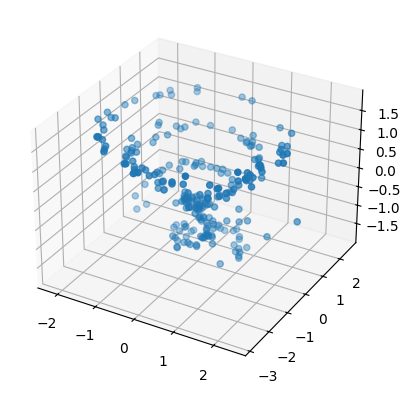

In [5]:
# rescale the data
dev_data, X_scaler, y_scaler = dataset.rescale_dataset(dev_data)
blind_data = dataset.rescale_dataset(blind_data, X_scaler)

# plot the dev data's targets on xyz axis
# the targets are the last 3 columns of the data
y = np.array(dev_data)[:, -3:]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:, 0], y[:, 1], y[:, 2])
plt.show()

# Model Definitions

In [6]:
def MLP() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 200),
        t.nn.Tanh(),
        t.nn.Linear(200, 200),
        t.nn.Tanh(),
        t.nn.Linear(200, 3)
    )


def MLPv2r() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 300),
        t.nn.ReLU(),
        t.nn.Linear(300, 300),
        t.nn.ReLU(),
        t.nn.Linear(300, 3)
    )


def MLPv2() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 300),
        t.nn.Tanh(),
        t.nn.Linear(300, 300),
        t.nn.Tanh(),
        t.nn.Linear(300, 3)
    )


def MLPv3() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 100),
        t.nn.Tanh(),
        t.nn.Linear(100, 200),
        t.nn.Tanh(),
        t.nn.Linear(200, 300),
        t.nn.Tanh(),
        t.nn.Linear(300, 3)
    )


def MLPv4() -> t.nn.Module:
    return t.nn.Sequential(
        t.nn.Linear(12, 50),
        t.nn.Tanh(),
        t.nn.Linear(50, 50),
        t.nn.Tanh(),
        t.nn.Linear(50, 3)
    )

# Grid search for the best parameters

# FullBatch

In [7]:
# Split the dev data into train and validation with k-fold cross validation
train_loaders, val_loaders, dev_loader, test_loader = dataset.torch_k_fold(dataset=dev_data, folds=5, batch_size=0,
                                                                           random_state=rand)
# blind test
from ML_cup.dataset_utils import CupDataset

blind_loader = DataLoader(CupDataset(blind_data, device=torch.device('cuda')), batch_size=len(blind_data))


# Model v1

In [26]:
parameters_SGD = [
    {
        'optimizer': 'SGD',
        'lr': np.linspace(0.0005, 0.0001, 5),
        'weight_decay': [0.001, 0.0025, 0.005],
        'momentum': [0.9, 0.95],
        'nesterov': [True, False]
    }]
parameters_Adam = [
    {
        'optimizer': 'Adam',
        'lr': np.linspace(0.0002, 0.0001, 10),
        'weight_decay': np.linspace(0.0001, 0.0005, 5)
    }
]

In [9]:
# perform grid search to find the best parameters
best_pytorch_params_s = grid_search(model_builder=MLP, parameters=parameters_SGD, random_seed=rand,
                                    train_loader=train_loaders,
                                    val_loader=val_loaders, max_epochs=1000,
                                    scheduler=('', {}),
                                    stability_threshold=1e-6, patience=5,
                                    clip=1.0,
                                    tensorboard_folder_base=f'runs/fullbatch/MLP/rescaled/SGD/{rand}',
                                    y_scaler=y_scaler)

Avg Train MEE: 0.1893395334482193, Avg Val MEE: 1.0675873756408691, Avg Fluctuation: 0.0
('SGD', {'lr': 0.0004, 'weight_decay': 0.0025, 'momentum': 0.95, 'nesterov': False}, 1.0)
Avg Train MEE: 0.18589898347854614, Avg Val MEE: 1.0671532034873963, Avg Fluctuation: 0.0
('SGD', {'lr': 0.0005, 'weight_decay': 0.0025, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 0.18557867109775544, Avg Val MEE: 1.051083791255951, Avg Fluctuation: 0.0
('SGD', {'lr': 0.0004, 'weight_decay': 0.001, 'momentum': 0.95, 'nesterov': False}, 1.0)
Avg Train MEE: 0.18149401396512985, Avg Val MEE: 1.0326043725013734, Avg Fluctuation: 0.0
('SGD', {'lr': 0.0005, 'weight_decay': 0.005, 'momentum': 0.95, 'nesterov': False}, 1.0)
Avg Train MEE: 0.17889950275421143, Avg Val MEE: 1.0513521432876587, Avg Fluctuation: 0.0
('SGD', {'lr': 0.0005, 'weight_decay': 0.0025, 'momentum': 0.95, 'nesterov': False}, 1.0)
Avg Train MEE: 0.1843420684337616, Avg Val MEE: 1.049501156806946, Avg Fluctuation: 0.0
('SGD', {'lr': 0.

In [27]:
# perform grid search to find the best parameters
best_pytorch_params_a = grid_search(model_builder=MLP, parameters=parameters_Adam, random_seed=rand,
                                    train_loader=train_loaders,
                                    val_loader=val_loaders, max_epochs=1000,
                                    scheduler=('', {}),
                                    stability_threshold=1e-5, patience=5,
                                    clip=1.0,
                                    tensorboard_folder_base=f'runs/fullbatch/MLP/rescaled/Adam/{rand}',
                                    y_scaler=y_scaler)

Avg Train MEE: 0.17399202287197113, Avg Val MEE: 1.033295178413391, Avg Fluctuation: 0.0
('Adam', {'lr': 0.0002, 'weight_decay': 0.0005}, 1.0)
Avg Train MEE: 0.1682464599609375, Avg Val MEE: 1.0350633025169373, Avg Fluctuation: 0.0
('Adam', {'lr': 0.00018888888888888888, 'weight_decay': 0.0002}, 1.0)
Avg Train MEE: 0.1719785213470459, Avg Val MEE: 1.055519962310791, Avg Fluctuation: 0.0
('Adam', {'lr': 0.0001666666666666667, 'weight_decay': 0.00030000000000000003}, 1.0)
Avg Train MEE: 0.16346171945333482, Avg Val MEE: 0.9615080118179321, Avg Fluctuation: 0.0
('Adam', {'lr': 0.0002, 'weight_decay': 0.0002}, 1.0)
Avg Train MEE: 0.1662312626838684, Avg Val MEE: 0.9789666295051574, Avg Fluctuation: 0.0
('Adam', {'lr': 0.00018888888888888888, 'weight_decay': 0.0005}, 1.0)
Avg Train MEE: 0.17037543952465056, Avg Val MEE: 1.0404887080192566, Avg Fluctuation: 0.0
('Adam', {'lr': 0.00017777777777777779, 'weight_decay': 0.0002}, 1.0)
Avg Train MEE: 0.1624378889799118, Avg Val MEE: 1.029174685478

In [28]:
print(best_pytorch_params_a)
#print(best_pytorch_params_s)

model_v1a = best_pytorch_params_a[1]
#model_v1s = best_pytorch_params_s[1]

# Evaluate the trained model on the test set
#print("Evaluating the SGD model on the test set")
#print(torch_predict(model_v1s, test_loader))

print("Evaluating the Adam model on the test set")
print(torch_predict(model_v1a, test_loader))

({'lr': 0.0001, 'weight_decay': 0.0005, 'optimizer': 'Adam'}, Sequential(
  (0): Linear(in_features=12, out_features=200, bias=True)
  (1): Tanh()
  (2): Linear(in_features=200, out_features=200, bias=True)
  (3): Tanh()
  (4): Linear(in_features=200, out_features=3, bias=True)
))
Evaluating the Adam model on the test set
0.36837175488471985


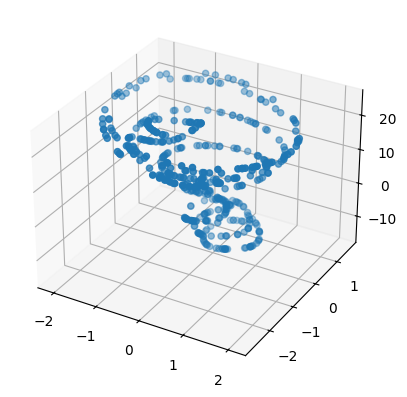

array([[ -1.0067469 ,  -1.1298041 ,  18.938715  ],
       [ -0.4539642 ,   1.4499613 ,  23.955097  ],
       [  0.7891938 ,   0.23754422, -14.530902  ],
       ...,
       [ -0.72275454,  -1.0455356 ,  18.70013   ],
       [  0.2969221 ,   0.76480955,  -7.665009  ],
       [  0.18067251,   0.21207248,  -3.128348  ]], dtype=float32)

In [29]:
blind_test(model_v1a, blind_loader, rand, y_scaler)
#blind_test(model_v1s, blind_loader, rand, y_scaler)

# Model v2

In [30]:
parameters = [
    {
        'optimizer': 'SGD',
        'lr': [0.005, 0.0025, 0.001],
        'weight_decay': [0.001, 0.005, 0.0015, 0.0025],
        'momentum': [0.8, 0.9],
        'nesterov': [True, False]
    },
    {
        'optimizer': 'Adam',
        'lr': np.linspace(0.0005, 0.0001, 5),
        'weight_decay': [0.0, 0.001, 0.0005]
    }
]
# perform grid search to find the best parameters
best_pytorch_params, model = grid_search(model_builder=MLPv2, parameters=parameters, train_loader=train_loaders,
                                         val_loader=val_loaders, scheduler=('', {}),
                                         patience=20, clip=1.0, stability_threshold=2e-4, max_epochs=1500,
                                         tensorboard_folder_base=f'runs/fullbatch/MLP2/scaled/{rand}',
                                         random_seed=rand, y_scaler=y_scaler)

Avg Train MEE: 0.17021625638008117, Avg Val MEE: 1.0218475937843323, Avg Fluctuation: 1.0370690524832165e-05
('SGD', {'lr': 0.005, 'weight_decay': 0.0025, 'momentum': 0.9, 'nesterov': True}, 1.0)
Avg Train MEE: 0.15807916820049286, Avg Val MEE: 0.9984168767929077, Avg Fluctuation: 9.986711253086333e-06
('SGD', {'lr': 0.005, 'weight_decay': 0.0015, 'momentum': 0.9, 'nesterov': True}, 1.0)
Avg Train MEE: 0.15510642528533936, Avg Val MEE: 1.0258606553077698, Avg Fluctuation: 5.063058276078708e-05
('SGD', {'lr': 0.005, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': False}, 1.0)
Avg Train MEE: 0.1536104381084442, Avg Val MEE: 1.0158097267150878, Avg Fluctuation: 3.1617912974356264e-05
('SGD', {'lr': 0.005, 'weight_decay': 0.0015, 'momentum': 0.9, 'nesterov': False}, 1.0)
Avg Train MEE: 0.14757218211889267, Avg Val MEE: 0.9775947213172913, Avg Fluctuation: 4.49724737101216e-05
('SGD', {'lr': 0.005, 'weight_decay': 0.0025, 'momentum': 0.9, 'nesterov': False}, 1.0)
Avg Train MEE: 0.139437

{'lr': 0.001, 'weight_decay': 0.0025, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'}
Evaluating the model on the test set
0.364273339509964


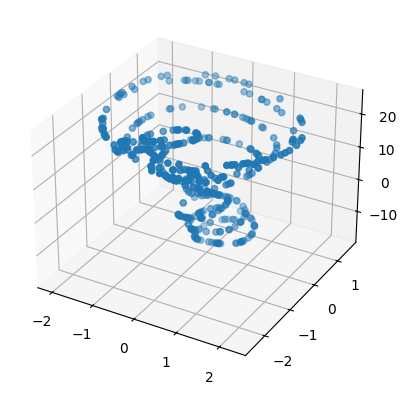

array([[ -0.5957792 ,  -1.6185017 ,  20.602642  ],
       [ -0.36576054,   1.4559704 ,  23.112255  ],
       [  0.75559455,   0.2009183 , -14.894961  ],
       ...,
       [ -0.34362102,  -1.4041638 ,  20.689806  ],
       [  0.2571668 ,   0.75499946,  -7.859389  ],
       [  0.1884474 ,   0.20230801,  -2.504917  ]], dtype=float32)

In [31]:
print(best_pytorch_params)
print("Evaluating the model on the test set")
print(torch_predict(model, test_loader))

blind_test(model, blind_loader, rand, y_scaler)

# Model v3

In [32]:
# perform grid search to find the best parameters
best_pytorch_params, model = grid_search(model_builder=MLPv3, parameters=parameters, train_loader=train_loaders,
                                         val_loader=val_loaders,
                                         scheduler=('', {}),
                                         clip=1.0, max_epochs=1500,
                                         stability_threshold=5e-4, patience=20,
                                         tensorboard_folder_base=f'runs/fullbatch/MLP3/scaled/{rand}',
                                         random_seed=rand, y_scaler=y_scaler)

Avg Train MEE: 0.13571573197841644, Avg Val MEE: 1.0513015866279602, Avg Fluctuation: 5.915345147598621e-06
('SGD', {'lr': 0.005, 'weight_decay': 0.0015, 'momentum': 0.9, 'nesterov': False}, 1.5)
Avg Train MEE: 0.1317647896707058, Avg Val MEE: 0.9992228865623474, Avg Fluctuation: 6.220284207113858e-06
('SGD', {'lr': 0.005, 'weight_decay': 0.0025, 'momentum': 0.9, 'nesterov': False}, 1.5)
Avg Train MEE: 0.13550014272332192, Avg Val MEE: 1.009011483192444, Avg Fluctuation: 0.0
('SGD', {'lr': 0.005, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': True}, 1.5)
Avg Train MEE: 0.12705607041716577, Avg Val MEE: 0.9847266912460327, Avg Fluctuation: 0.0
('SGD', {'lr': 0.005, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': False}, 1.5)
Avg Train MEE: 0.13343013748526572, Avg Val MEE: 0.9586828231811524, Avg Fluctuation: 0.0
('SGD', {'lr': 0.005, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': False}, 1.5)
Avg Train MEE: 0.15598299950361252, Avg Val MEE: 0.9994848847389222, Avg Fluctua

{'lr': 0.0001, 'weight_decay': 0.0005, 'optimizer': 'Adam'}
Evaluating the model on the test set
0.3046625256538391


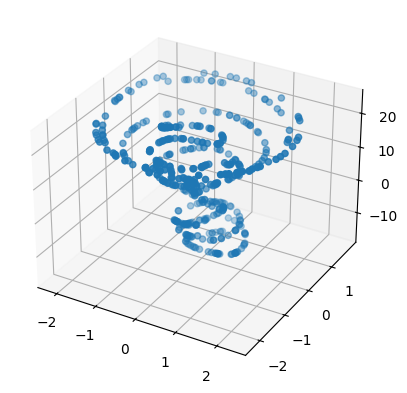

array([[ -0.36756805,  -1.0272433 ,  21.137789  ],
       [ -0.40738428,   1.7711929 ,  23.284943  ],
       [  0.89848316,  -0.0259054 , -13.975804  ],
       ...,
       [ -0.16609223,  -0.7767337 ,  21.290325  ],
       [  0.19870912,   0.82497734,  -8.049556  ],
       [  0.28717494,   0.13744433,  -2.3332393 ]], dtype=float32)

In [33]:
print(best_pytorch_params)
print("Evaluating the model on the test set")
print(torch_predict(model, test_loader))

blind_test(model, blind_loader, rand, y_scaler)

# Model v4

In [34]:
#perform grid search to find the best parameters
best_pytorch_params, model = grid_search(model_builder=MLPv4, parameters=parameters, train_loader=train_loaders,
                                         val_loader=val_loaders,
                                         scheduler=('', {}),
                                         clip=1.0, max_epochs=1500,
                                         stability_threshold=0.1, patience=20,
                                         tensorboard_folder_base=f'runs/fullbatch/MLP4/scaled/{rand}',
                                         random_seed=rand, y_scaler=y_scaler)

Avg Train MEE: 0.1140342816710472, Avg Val MEE: 0.9558607697486877, Avg Fluctuation: 0.0
('SGD', {'lr': 0.005, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': True}, 1.0)
Avg Train MEE: 0.11441630870103836, Avg Val MEE: 0.9384058952331543, Avg Fluctuation: 0.0
('SGD', {'lr': 0.005, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': False}, 1.0)
Avg Train MEE: 0.09674734175205231, Avg Val MEE: 0.920131516456604, Avg Fluctuation: 0.0
('SGD', {'lr': 0.005, 'weight_decay': 0.0015, 'momentum': 0.9, 'nesterov': False}, 1.0)
Avg Train MEE: 0.13192129731178284, Avg Val MEE: 1.0058264255523681, Avg Fluctuation: 0.0
('SGD', {'lr': 0.0025, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': True}, 1.0)
Avg Train MEE: 0.13601598143577576, Avg Val MEE: 0.9624814987182617, Avg Fluctuation: 0.0
('SGD', {'lr': 0.005, 'weight_decay': 0.0015, 'momentum': 0.8, 'nesterov': False}, 1.0)
Avg Train MEE: 0.09330964982509612, Avg Val MEE: 0.8905421495437622, Avg Fluctuation: 0.0
('SGD', {'lr': 0.005, 'wei

# Minibatch

In [7]:
# Split the dev data into train and validation with k-fold cross validation
train_loaders, val_loaders, dev_loader, test_loader = dataset.torch_k_fold(dataset=dev_data, folds=5, batch_size=20,
                                                                           random_state=rand)
# blind test
from ML_cup.dataset_utils import CupDataset

blind_loader = DataLoader(CupDataset(blind_data, device=torch.device('cuda')))

# Model v1

## SGD

In [8]:
parameters = [
    {
        'optimizer': 'SGD',
        'lr': np.linspace(0.0075, 0.000075, 5),
        'weight_decay': np.linspace(0.01, 0.00001, 5),
        'momentum': [0.9, 0.95, 0.8],
        'nesterov': [True, False]
    }
]
# perform grid search to find the best parameters
best_pytorch_params, best_model = grid_search(model_builder=MLP, parameters=parameters, random_seed=rand,
                                              train_loader=train_loaders,
                                              val_loader=val_loaders, max_epochs=1500,
                                              scheduler=('', {}),
                                              stability_threshold=0.25, patience=10,
                                              clip=1.0,
                                              tensorboard_folder_base=f'runs/minibatch/MLP/SGD/rescaled/{rand}',
                                              y_scaler=y_scaler)

Avg Train MEE: 0.07726203128695489, Avg Val MEE: 0.8003688395023346, Avg Fluctuation: 0.00038417393614553926
('SGD', {'lr': 0.0075, 'weight_decay': 0.005005, 'momentum': 0.95, 'nesterov': False}, 1.0)
Avg Train MEE: 0.08074971046298743, Avg Val MEE: 0.8016437351703644, Avg Fluctuation: 0.00018651328335124285
('SGD', {'lr': 0.0075, 'weight_decay': 0.005005, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 0.08650742378085852, Avg Val MEE: 0.8305529296398163, Avg Fluctuation: 0.00023387086443917975
('SGD', {'lr': 0.0075, 'weight_decay': 0.0075025000000000005, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 0.09689777344465256, Avg Val MEE: 0.826321804523468, Avg Fluctuation: 0.00038736939877575226
('SGD', {'lr': 0.0075, 'weight_decay': 0.0075025000000000005, 'momentum': 0.95, 'nesterov': False}, 1.0)
Avg Train MEE: 0.09529561884701251, Avg Val MEE: 0.8328437983989716, Avg Fluctuation: 0.0001080192247214382
('SGD', {'lr': 0.0075, 'weight_decay': 0.0025074999999999993, 'mo

{'lr': 7.5e-05, 'weight_decay': 1e-05, 'momentum': 0.8, 'nesterov': False, 'optimizer': 'SGD'}
Evaluating the model on the test set
0.3173479735851288


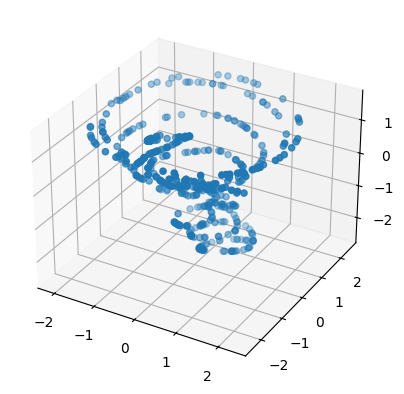

array([[-0.4143124 , -1.223731  ,  1.113645  ],
       [-0.14364684,  2.4641728 ,  1.5244931 ],
       [ 0.8812156 ,  0.22288297, -2.171734  ],
       ...,
       [-0.24291864, -1.0134867 ,  1.188079  ],
       [ 0.31765804,  1.0519263 , -1.5728747 ],
       [ 0.12123019,  0.45677698, -1.0783222 ]], dtype=float32)

In [9]:
# retrain the model with the best parameters on the whole dataset
print(best_pytorch_params)
model_v1 = best_model
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v1, test_loader))

blind_test(model_v1, blind_loader, rand)

## Adam

Avg Train MEE: 0.09801200404763222, Avg Val MEE: 0.8793789625167847, Avg Fluctuation: 8.450534049819137e-05
('Adam', {'lr': 0.0005, 'weight_decay': 0.001}, 1.0)
Avg Train MEE: 0.09046418461948633, Avg Val MEE: 0.8557310581207276, Avg Fluctuation: 0.00012188154105939998
('Adam', {'lr': 0.0005, 'weight_decay': 0.00011999999999999999}, 1.0)
Avg Train MEE: 0.09053789358586073, Avg Val MEE: 0.8396466851234436, Avg Fluctuation: 9.061634029138679e-05
('Adam', {'lr': 0.00045555555555555556, 'weight_decay': 0.00078}, 1.0)
Avg Train MEE: 0.09514100793749095, Avg Val MEE: 0.8409848988056183, Avg Fluctuation: 8.05089477720012e-05
('Adam', {'lr': 0.00045555555555555556, 'weight_decay': 0.00022999999999999995}, 1.0)
Avg Train MEE: 0.08942181710153818, Avg Val MEE: 0.844038051366806, Avg Fluctuation: 0.00011392653469434015
('Adam', {'lr': 0.00045555555555555556, 'weight_decay': 0.00067}, 1.0)
Avg Train MEE: 0.08340901900082827, Avg Val MEE: 0.8507197558879852, Avg Fluctuation: 0.00015237397975548922


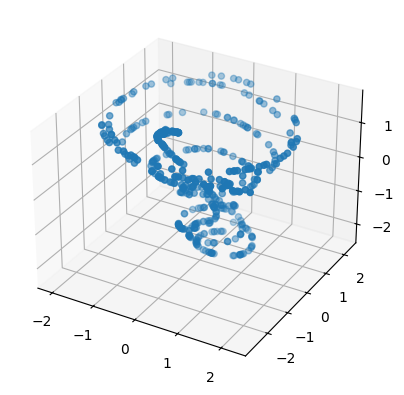

array([[-0.5613499 , -0.89512104,  1.3137128 ],
       [-0.3082336 ,  2.28278   ,  1.5427437 ],
       [ 0.88751227,  0.27443644, -2.2130766 ],
       ...,
       [-0.59925777, -0.72157025,  1.3069794 ],
       [ 0.24902898,  1.0585612 , -1.5877831 ],
       [ 0.0898943 ,  0.39486322, -1.0744705 ]], dtype=float32)

In [10]:
parameters = [
    {
        'optimizer': 'Adam',
        'lr': np.linspace(0.0005, 0.0001, 10),
        'weight_decay': np.linspace(0.001, 0.00001, 10),
    }]

best_pytorch_params, best_model = grid_search(model_builder=MLP, parameters=parameters, random_seed=rand,
                                              train_loader=train_loaders, val_loader=val_loaders,
                                              scheduler=('', {}), max_epochs=1500,
                                              stability_threshold=0.25, patience=10,
                                              clip=1.0,
                                              tensorboard_folder_base=f'runs/minibatch/MLP/Adam/rescaled/{rand}',
                                              y_scaler=y_scaler)
# retrain the model with the best parameters on the whole dataset
print(best_pytorch_params)
model_v1 = best_model
# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v1, test_loader))

blind_test(model_v1, blind_loader, rand, y_scaler=y_scaler)

# Model v2

## Relu

Avg Train MEE: 0.0801607240922749, Avg Val MEE: 0.8559084117412568, Avg Fluctuation: 0.00021759606214615256
('Adam', {'lr': 0.0006944444444444445, 'weight_decay': 0.0}, 1.0)
Avg Train MEE: 0.07724053477868438, Avg Val MEE: 0.8344375729560852, Avg Fluctuation: 0.0001088761270608488
('Adam', {'lr': 0.0005833333333333333, 'weight_decay': 0.0}, 1.0)
Avg Train MEE: 0.07935787141323089, Avg Val MEE: 0.8482280731201172, Avg Fluctuation: 0.00026108751833524513
('Adam', {'lr': 0.0006944444444444445, 'weight_decay': 0.0005}, 1.0)
Avg Train MEE: 0.0816157571040094, Avg Val MEE: 0.9069685816764832, Avg Fluctuation: 0.00023253642846305178
('Adam', {'lr': 0.00075, 'weight_decay': 0.0}, 1.0)
Avg Train MEE: 0.07686881814152002, Avg Val MEE: 0.8551897525787353, Avg Fluctuation: 0.0002562860443850552
('Adam', {'lr': 0.0005277777777777778, 'weight_decay': 0.0005}, 1.0)
Avg Train MEE: 0.07908172886818647, Avg Val MEE: 0.8619615912437439, Avg Fluctuation: 0.00023225470987789888
('Adam', {'lr': 0.00075, 'we

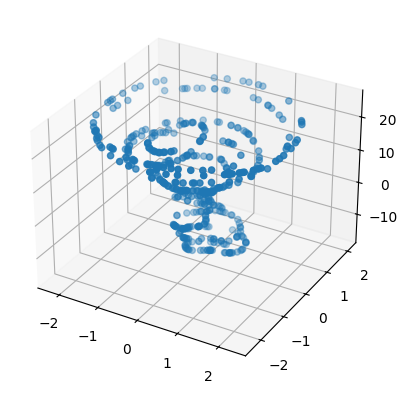

array([[-6.3070166e-01, -1.1229134e+00,  1.5826853e+01],
       [-1.4568713e-01,  2.0873287e+00,  2.3940441e+01],
       [ 7.7102625e-01,  1.6652064e-02, -1.3409797e+01],
       ...,
       [-2.4636392e-01, -1.1159312e+00,  1.6881563e+01],
       [ 3.3419663e-01,  7.6384449e-01, -7.9393516e+00],
       [ 3.9512539e-01,  2.4299566e-01, -2.2686908e+00]], dtype=float32)

In [11]:
parameters = [
    {
        'optimizer': 'Adam',
        'lr': np.linspace(0.00075, 0.00025, 10),
        'weight_decay': [0.0, 0.001, 0.0005]
    }]

best_pytorch_params, best_model = grid_search(model_builder=MLPv2r, parameters=parameters, random_seed=rand,
                                              train_loader=train_loaders, val_loader=val_loaders,
                                              scheduler=('', {}), max_epochs=1500,
                                              stability_threshold=0.25, patience=10,
                                              clip=1.0, tensorboard_folder_base=f'runs/minibatch/MLP/Adam/relu/{rand}',
                                              y_scaler=y_scaler)
print(best_pytorch_params, best_model)

# test the model on the test set
print("Evaluating the model on the test set")
print(torch_predict(best_model, test_loader))

blind_test(best_model, blind_loader, rand, y_scaler=y_scaler)

## Tanh

In [12]:
parameters = [
    {
        'optimizer': 'SGD',
        'lr': np.linspace(0.0025, 0.0001, 5),
        'weight_decay': [0.001, 0.005, 0.0015, 0.0025],
        'momentum': [0.9, 0.95],
        'nesterov': [True]
    },
    {
        'optimizer': 'Adam',
        'lr': np.linspace(0.0003, 0.000075, 10),
        'weight_decay': np.linspace(0.0001, 0.0005, 10),
    }
]

# perform grid search to find the best parameters
best_pytorch_params, best_model = grid_search(model_builder=MLPv2, parameters=parameters, train_loader=train_loaders,
                                              val_loader=val_loaders, scheduler=('', {}), max_epochs=1500,
                                              patience=20, clip=1.0, stability_threshold=0.2,
                                              tensorboard_folder_base=f'runs/minibatch/MLP2/scaled/{rand}',
                                              random_seed=rand, y_scaler=y_scaler)

Avg Train MEE: 0.08264935743063688, Avg Val MEE: 0.7957306921482086, Avg Fluctuation: 0.0001310924365329128
('SGD', {'lr': 0.0025, 'weight_decay': 0.0025, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 0.07795700635761023, Avg Val MEE: 0.7969297945499421, Avg Fluctuation: 6.576525273389786e-05
('SGD', {'lr': 0.0019, 'weight_decay': 0.0015, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 0.10514125376939773, Avg Val MEE: 0.842697125673294, Avg Fluctuation: 0.00014829659369158506
('SGD', {'lr': 0.0019, 'weight_decay': 0.005, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 0.08130856100469827, Avg Val MEE: 0.7928978502750397, Avg Fluctuation: 0.00014191515327514545
('SGD', {'lr': 0.0025, 'weight_decay': 0.0015, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 0.08089693188667298, Avg Val MEE: 0.7933745443820953, Avg Fluctuation: 0.00012153207209396189
('SGD', {'lr': 0.0025, 'weight_decay': 0.005, 'momentum': 0.95, 'nesterov': True}, 1.0)
Avg Train MEE: 

{'lr': 0.0001, 'weight_decay': 0.0025, 'momentum': 0.95, 'nesterov': True, 'optimizer': 'SGD'}
Evaluating the model on the test set
0.3130148947238922


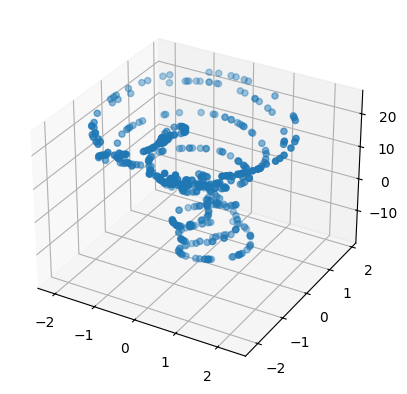

array([[-6.3087648e-01, -1.0772227e+00,  1.8516333e+01],
       [-3.8205329e-01,  1.8854113e+00,  2.3640799e+01],
       [ 1.0155644e+00,  4.1783646e-02, -1.4726745e+01],
       ...,
       [-4.9970198e-01, -8.3821285e-01,  1.9136702e+01],
       [ 2.0225273e-01,  7.6318634e-01, -7.9242530e+00],
       [ 2.3134891e-02,  2.4218161e-01, -2.8088911e+00]], dtype=float32)

In [13]:
print(best_pytorch_params)

model_v2 = best_model

# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v2, test_loader))

blind_test(model_v2, blind_loader, rand, y_scaler=y_scaler)

# Model v3

In [8]:
parameters_sgd3 = [
    {
        'optimizer': 'SGD',
        'lr': np.linspace(0.00075, 0.0001, 5),
        'weight_decay': [0.001, 0.0005, 0.0015, 0.0025],
        'momentum': [0.8, 0.9],
        'nesterov': [True]
    }]
parameters_adam3 = [
    {
        'optimizer': 'Adam',
        'lr': np.linspace(0.000025, 0.0000075, 5),
        'weight_decay': np.linspace(0.0001, 0.00005, 10)
    }]

Avg Train MEE: 0.07777030449360608, Avg Val MEE: 0.847249549627304, Avg Fluctuation: 5.103269357885276e-06
('SGD', {'lr': 0.00075, 'weight_decay': 0.0015, 'momentum': 0.9, 'nesterov': True}, 1.0)
Avg Train MEE: 0.07413634415715933, Avg Val MEE: 0.7882896661758423, Avg Fluctuation: 5.002651868650706e-06
('SGD', {'lr': 0.0005875, 'weight_decay': 0.0005, 'momentum': 0.9, 'nesterov': True}, 1.0)
Avg Train MEE: 0.06257003545761108, Avg Val MEE: 0.7843100130558014, Avg Fluctuation: 2.4491865611509786e-06
('SGD', {'lr': 0.00042500000000000003, 'weight_decay': 0.0005, 'momentum': 0.9, 'nesterov': True}, 1.0)
Avg Train MEE: 0.06787323616445065, Avg Val MEE: 0.7775063335895538, Avg Fluctuation: 4.91805250113563e-06
('SGD', {'lr': 0.00075, 'weight_decay': 0.0015, 'momentum': 0.8, 'nesterov': True}, 1.0)
Avg Train MEE: 0.08310870081186295, Avg Val MEE: 0.8113261580467224, Avg Fluctuation: 3.3557343572331805e-06
('SGD', {'lr': 0.0005875, 'weight_decay': 0.0025, 'momentum': 0.8, 'nesterov': True}, 1

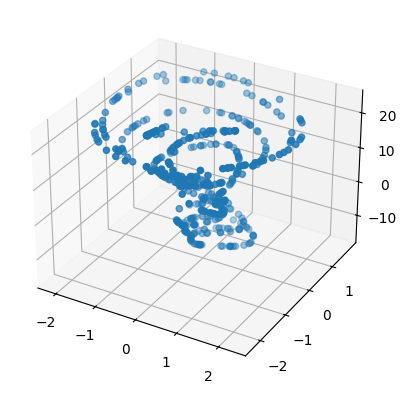

array([[-6.8565090e-03, -1.1901977e+00,  2.0804537e+01],
       [-4.7293544e-01,  1.7625690e+00,  2.2818193e+01],
       [ 6.3246316e-01,  2.1727608e-01, -1.3994256e+01],
       ...,
       [ 3.3868622e-02, -7.9146379e-01,  2.1111904e+01],
       [ 2.1147037e-01,  7.4510825e-01, -7.6943984e+00],
       [ 2.4513909e-01,  1.6381030e-01, -2.7198617e+00]], dtype=float32)

In [9]:
# perform grid search to find the best parameters
best_pytorch_params, model_v3 = grid_search(model_builder=MLPv3, parameters=parameters_sgd3,
                                              train_loader=train_loaders,
                                              val_loader=val_loaders,
                                              scheduler=('', {}),
                                              clip=1.0, max_epochs=1500,
                                              stability_threshold=5e-5, patience=20,
                                              tensorboard_folder_base=f'runs/minibatch/MLP3/rescaled/SGD/{rand}',
                                              random_seed=rand, y_scaler=y_scaler)
# retrain the model with the best parameters
# best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}
print(best_pytorch_params)

# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v3, test_loader))

blind_test(model_v3, blind_loader, rand, y_scaler=y_scaler)

Avg Train MEE: 0.10706271082162858, Avg Val MEE: 0.8957499861717224, Avg Fluctuation: 5.391290169061184e-06
('Adam', {'lr': 2.5e-05, 'weight_decay': 7.222222222222222e-05}, 1.0)
Avg Train MEE: 0.09569683037698269, Avg Val MEE: 0.8578764796257019, Avg Fluctuation: 4.304439837264272e-06
('Adam', {'lr': 2.5e-05, 'weight_decay': 9.444444444444444e-05}, 1.0)
Avg Train MEE: 0.09998705387115478, Avg Val MEE: 0.8593596875667572, Avg Fluctuation: 4.584766945110112e-06
('Adam', {'lr': 2.5e-05, 'weight_decay': 8.888888888888889e-05}, 1.0)
Avg Train MEE: 0.0968595203012228, Avg Val MEE: 0.8814314067363739, Avg Fluctuation: 3.4830421112806075e-06
('Adam', {'lr': 2.0625e-05, 'weight_decay': 5.555555555555556e-05}, 1.0)
Avg Train MEE: 0.09452157765626908, Avg Val MEE: 0.8765612602233886, Avg Fluctuation: 3.2492240049800633e-06
('Adam', {'lr': 2.0625e-05, 'weight_decay': 7.777777777777778e-05}, 1.0)
Avg Train MEE: 0.09738877452909947, Avg Val MEE: 0.8564863085746766, Avg Fluctuation: 4.11391773770672e

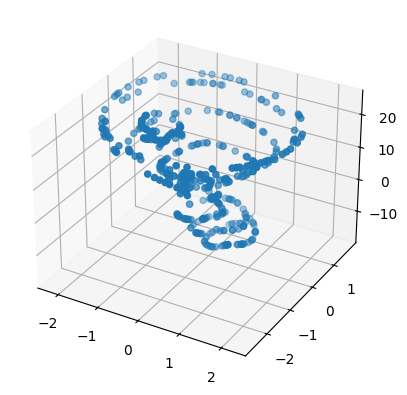

array([[ -0.96875495,  -1.0403976 ,  19.516172  ],
       [ -0.61571366,   1.7428684 ,  23.09446   ],
       [  0.8306686 ,   0.05282158, -13.575179  ],
       ...,
       [ -0.81274724,  -1.0007879 ,  19.378506  ],
       [  0.20528439,   0.8832261 ,  -8.267173  ],
       [  0.05605011,   0.0860229 ,  -2.7094152 ]], dtype=float32)

In [9]:
# perform grid search to find the best parameters
best_pytorch_params, model_v3 = grid_search(model_builder=MLPv3, parameters=parameters_adam3,
                                              train_loader=train_loaders,
                                              val_loader=val_loaders,
                                              scheduler=('', {}),
                                              clip=1.0, max_epochs=1500,
                                              stability_threshold=5e-5, patience=20,
                                              tensorboard_folder_base=f'runs/minibatch/MLP3/rescaled/Adam/{rand}',
                                              random_seed=rand, y_scaler=y_scaler)
# retrain the model with the best parameters
# best_pytorch_params = {'lr': 0.001, 'weight_decay': 0.005, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}
print(best_pytorch_params)

# Evaluate the trained model on the test set
print("Evaluating the model on the test set")
print(torch_predict(model_v3, test_loader))

blind_test(model_v3, blind_loader, rand, y_scaler=y_scaler)
